# Instructions

1. This assignment is worth 5% of the final grade.
2. In the questions below, insert a cell (code or markdown, as appropriate), and fill in your answers there.
2. You are required to work on this individually. Any form of plagiarism will result in 0.
3. Please submit your notebook file (name it `IND5003_A2_<Your_Name>.ipynb`) through Canvas before **17th Nov 2023 23:59hrs**.

# Question 1

In Python, you can save a binary version of an object by pickling it. The file `IND5003_2310_Assignment2.pickle` contains the training and test data that we used in class for the KNN model. The pickle was created in this way:

To read pickled objects into your notebook, you can do this:

In [1]:
# import pickle

# with open('../data/IND5003_2310_Assignment2.pickle', 'rb') as f:
#     X_ttrain, X_ttest, y_train, y_test = pickle.load(f)

If this does not work for you, run the following cell to obtain `X_ttrain`, `X_ttest`, `y_train`, `y_test`.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn import set_config
set_config(display='diagram')

In [3]:
set_config(display='diagram')

loans = pd.read_excel('../data/loans.xlsx', index_col=0)
loans.loc[:, 'issue_yr'] = loans.issue_d.apply(lambda x: x.year)
loans.loc[:, 'issue_mth'] = loans.issue_d.apply(lambda x: x.month)
drop_these_columns = loans.apply(lambda x: np.sum(pd.notna(x)), axis=0) < 40000
loans.drop(columns=loans.columns[drop_these_columns], inplace=True)
no_miss = loans[pd.notna(loans).all(axis=1)].copy()
cr_line_cols = no_miss.earliest_cr_line.str.split('-', expand=True)
cr_line_cols.columns = ['ecrl_mth', 'ecrl_yr']
cr_line_cols.ecrl_yr = cr_line_cols.ecrl_yr.astype(int)
no_miss = pd.concat([no_miss, cr_line_cols], axis=1)
y = no_miss.y
X_train, X_test, y_train, y_test = train_test_split(no_miss, y, test_size=0.3, random_state=41, stratify=y)

num_features = ['loan_amnt', 'int_rate', 'installment', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'issue_yr']
cat_features = ['term', 'grade', 'emp_length', 'home_ownership', 'loan_status', 'purpose', 'addr_state']
all_features = num_features + cat_features
X_train = X_train.loc[:, all_features]
X_test = X_test.loc[:, all_features]
ct = ColumnTransformer([
      ('scale', StandardScaler(), make_column_selector(dtype_include=np.number)),
      ('onehot', OneHotEncoder(), make_column_selector(dtype_include=object))])
ct.fit(X_train)
X_ttrain = ct.transform(X_train)
X_ttest = ct.transform(X_test)

1. A logistic regression classifier is a widely used classification model. It models the log-odds for a class as a linear combination of one or more independent variables. **With L2 regularization,** the hyper-parameter is C, the inverse of regularization strength. Create a sklearn logistic regression classifier with L2 regularization, `random_state=42` and `solver='saga'`, then generate and plot the validation curve by varying C over the range from 1 to 3001 (inclusive of both endpoints) with at least 16 different values.
2. Apply the best estimator to the *test set*, and compare the confusion matrix to the KNN model. In class, it achieved an accuracy of 0.89 and an F1-score of 0.58.

In [4]:
X_train.head()

,loan_amnt,int_rate,installment,total_pymnt,total_pymnt_inv,total_rec_prncp,issue_yr,term,grade,emp_length,home_ownership,loan_status,purpose,addr_state
7810,3600,7.49,111.97,3948.400000,3920.99,3600.00,2011,36 months,A,< 1 year,MORTGAGE,Fully Paid,other,MN
19404,12000,10.74,391.39,13113.380000,13058.73,12000.00,2011,36 months,B,9 years,MORTGAGE,Fully Paid,small_business,FL
10432,12000,8.49,246.15,14592.554033,14288.49,12000.00,2011,60 months,A,10+ years,MORTGAGE,Fully Paid,vacation,CA
8207,14000,12.99,318.48,17072.850000,17072.85,14000.01,2011,60 months,C,10+ years,MORTGAGE,Fully Paid,debt_consolidation,VA
19315,6000,13.80,204.49,7358.823689,7358.82,6000.00,2011,36 months,C,< 1 year,RENT,Fully Paid,debt_consolidation,NY


In [16]:
X_ttrain[:10, :7].toarray().round(5)

array([[-1.02091, -1.2695 , -1.0178 , -0.90922, -0.83888, -0.87113,
         0.80281],
       [ 0.10636, -0.39084,  0.31161,  0.12204,  0.19729,  0.33504,
         0.80281],
       [ 0.10636, -0.99915, -0.3794 ,  0.28848,  0.33674,  0.33504,
         0.80281],
       [ 0.37476,  0.21746, -0.03528,  0.56757,  0.65247,  0.62222,
         0.80281],
       [-0.69883,  0.43645, -0.57761, -0.52547, -0.44905, -0.52651,
         0.80281],
       [-0.69883, -1.32357, -0.98135, -0.64786, -0.57239, -0.52651,
         0.80281],
       [-0.16203, -0.22322,  0.01534, -0.12527, -0.06122,  0.04786,
        -0.24716],
       [-0.83303,  0.31479, -0.74494, -0.70522, -0.63672, -0.6701 ,
        -0.24716],
       [ 0.10636, -0.09616,  0.3412 ,  0.16684,  0.23584,  0.14876,
        -1.29713],
       [ 0.10636,  0.34723, -0.76369, -0.70718, -1.1115 , -0.68805,
        -1.29713]])

In [13]:
# Setting the range for C
C_range = np.linspace(1, 3001, 16)

In [18]:

# Creating logistic regression classifier with L2 regularization
log_reg = LogisticRegression(random_state=42, solver='saga', penalty='l2', max_iter=100000)

In [19]:
# Generating validation curve
train_scores, test_scores = validation_curve(
    log_reg, X_ttrain, y_train, param_name="C", param_range=C_range,
    scoring="accuracy", n_jobs=-1)

# # Calculate validation curve
# train_scores_lin, test_scores_lin = validation_curve(
#     logistic_regression, X_ttrain, y_train, param_name="C", param_range=C_values_lin,
#     cv=5, scoring="accuracy", n_jobs=-1)

In [20]:
# Calculating mean and standard deviation for train and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

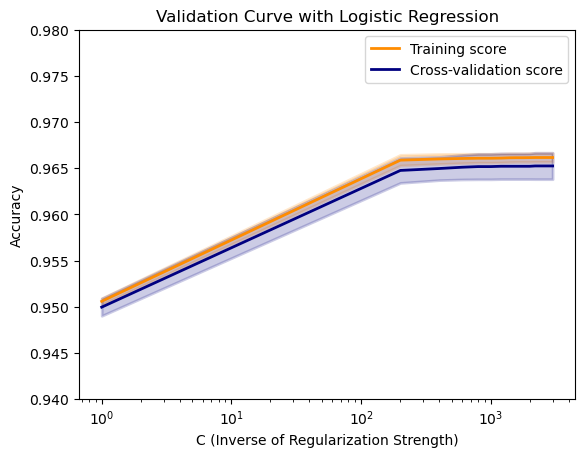

array([2201., 2401., 2601., 2801., 3001.])

In [39]:
# Plotting the validation curve
plt.figure()
plt.title("Validation Curve with Logistic Regression")
plt.xlabel("C (Inverse of Regularization Strength)")
plt.ylabel("Accuracy")
plt.ylim(0.94, 0.98)
lw = 2
plt.semilogx(C_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(C_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(C_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(C_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

# Outputting the C values with the best test scores
best_C_indices = np.argsort(-test_scores_mean)
best_C_values = C_range[best_C_indices]
best_C_values[:5]  # Displaying the top 5 C values

In [22]:
# Outputting the C values with the best test scores
best_C_indices = np.argsort(-test_scores_mean)
best_C_values = C_range[best_C_indices]
best_C_values[:5]  # Displaying the top 5 C values

array([2201., 2401., 2601., 2801., 3001.])

### Q1 Part 2      
Apply best estimator to the test set.

In [25]:
# Creating logistic regression classifier with L2 regularization
log_reg = LogisticRegression(random_state=42, solver='saga', penalty='l2', max_iter=100000, C=2201)

In [27]:
log_reg.fit(X_ttrain, y_train)

LogisticRegression(C=2201, max_iter=100000, random_state=42, solver='saga')

In [29]:
y_pred = log_reg.predict(X_ttest)

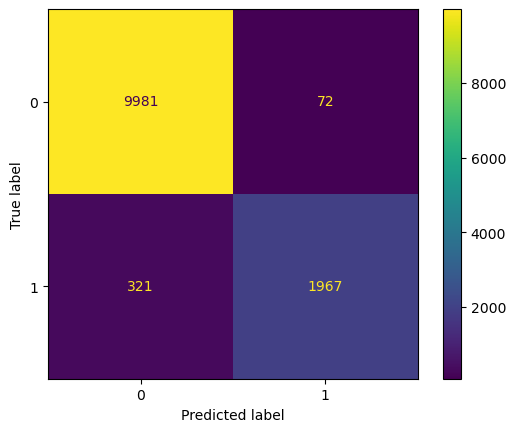

In [34]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=log_reg.classes_).plot();

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     10053
           1       0.96      0.86      0.91      2288

    accuracy                           0.97     12341
   macro avg       0.97      0.93      0.94     12341
weighted avg       0.97      0.97      0.97     12341



# Question 2

Review the section on 'Running Detections Programmatically' in `08_vision_lecture.ipynb`. Recall that the YOLOv4 model detected 12 objects in `football1.png` and all 12 objects were labeled `person`.

Modify `vision.py` and then use it with the codes in the section on 'Running Detections Programmatically' to detect the objects in `train_station_bournemouth.jpg` and **report all the labels detected and how many objects there were of each label.**

1. In the cell below, include the lines you modify in or/and add to `vision.py` and say where the lines are.
2. Insert other cells after this next cell and fill in the codes you use to detect the objects in `train_station_bournemouth.jpg` and report all the labels detected and how many objects there were of each label.

In [ ]:
# Fill in the details of how you modified vision.py here:
#
# Modify line xxx

# Insert after line yyy


## References

1. The Python [pickle module](https://docs.python.org/3/library/pickle.html)
2. More details on logistic regression - see section 4.3 in [this book](https://www.statlearning.com/).
3. sklearn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) on logistic regression.